## Imports

In [1]:
import re
from collections import defaultdict
from difflib import get_close_matches

import numpy as np
import pandas as pd
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm

from khan_helpers import Experiment, Participant
from khan_helpers.constants import DATA_DIR, FIG_DIR, RAW_DIR
from khan_helpers.functions import (
    interp_lecture, 
    parse_windows,
    preprocess_text,
    synset_match
)

from matplotlib.patches import Rectangle
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

## Define some functions

In [2]:
class ParamData:
    def __init__(self, n_topics, window_size, corpus_key):
        self.n_topics = n_topics
        self.window_size = window_size
        self.corpus_key = corpus_key
        
        self.forces_traj = None
        self.bos_traj = None
        self.forces_questions = None
        self.bos_questions = None
        self.cv = None
        self.lda = None
        self.score = None
        
    def __repr__(self):
        params = f"(n_topics: {self.n_topics}, window_size: {self.window_size}, corpus_key: {self.corpus_key})"
        score = f"score: {self.score}"
        return f"{params}\n{score}"
    
    def __str__(self):
        return repr(self)
    
    def __eq__(self, other):
        return self.score == other.score
    
    def __ne__(self, other):
        return self.score != other.score
    
    def __gt__(self, other):
        return self.score > other.score
    
    def __ge__(self, other):
        return self.score >= other.score
    
    def __lt__(self, other):
        return self.score < other.score
    
    def __le__(self, other):
        return self.score <= other.score

    def fit_transform_data(self):
        forces_windows, forces_timestamps = parse_windows(ff_transcript_processed, 
                                                          self.window_size)
        bos_windows, bos_timestamps = parse_windows(bos_transcript_processed, 
                                                    self.window_size)
        forces_question_text = list(quiz_text_processed[:15, 0])
        bos_question_text = list(quiz_text_processed[15:30, 0])
        
        corpus = forces_windows + bos_windows + create_qa_corpus(self.corpus_key)
        self.cv = CountVectorizer(**CV_PARAMS)
        self.lda = LatentDirichletAllocation(n_components=self.n_topics, **LDA_PARAMS)
        self.lda.fit(self.cv.fit_transform(corpus))
        
        forces_traj = self.lda.transform(self.cv.transform(forces_windows))
        bos_traj = self.lda.transform(self.cv.transform(bos_windows))
        
        self.forces_traj = interp_lecture(forces_traj, forces_timestamps)
        self.bos_traj = interp_lecture(bos_traj, bos_timestamps)
        self.forces_questions = self.lda.transform(self.cv.transform(forces_question_text))
        self.bos_questions = self.lda.transform(self.cv.transform(bos_question_text))

    def score_models(self):
        forces_score = self._score_single_lec(self.forces_traj, self.forces_questions)
        bos_score = self._score_single_lec(self.bos_traj, self.bos_questions)
        self.score = (forces_score + bos_score) / 2
        return self.score
        
    def _score_single_lec(self, lec_traj, questions):
        qq_corrmat = np.corrcoef(questions)
        qq_corrs = qq_corrmat[np.triu_indices_from(qq_corrmat, k=1)]
        
        lq_corrs = 1 - cdist(lec_traj, questions, 'correlation')
        max_tpts = lq_corrs.argmax(axis=0)
        max_tpt_distmat = np.abs(max_tpts[:, np.newaxis] - max_tpts)
        max_tpt_dists = max_tpt_distmat[np.triu_indices_from(max_tpt_distmat, k=1)]
        
        return -pearsonr(max_tpt_dists, qq_corrs)[0]

In [3]:
def create_qa_corpus(corpus_key):
    qa_corpus = []
    if 'Q' in corpus_key:
        # include all questions
        q_rows = quiz_text_processed[:]
    elif 'q' in corpus_key:
        # include lecture-related questions
        q_rows = quiz_text_processed[:30]
    else:
        # no questions (or answers) included
        return []
    
    qa_corpus.extend(q_rows[:, 0])
    if 'A' in corpus_key:
        # all answer choices
        qa_corpus.extend(q_rows[:, 1:].ravel())
    elif 'a' in corpus_key:
        # correct answers only
        qa_corpus.extend(q_rows[:, 1])
        
    return qa_corpus

In [4]:
def model_params(n_topics, window_size, corpus_key, objs_list):
    # if param combination has already been run, return object
    for obj in objs_list:
        if (obj.n_topics == n_topics and 
            obj.window_size == window_size and 
            obj.corpus_key == corpus_key):
            return obj
        
    new_obj = ParamData(n_topics, window_size, corpus_key)
    new_obj.fit_transform_data()
    new_obj.score_models()
    objs_list.append(new_obj)
    return new_obj

In [5]:
def corpus_heatmap(x_dim, y_dim, max_val, **sns_kwargs):
    facet_data = sns_kwargs.pop('data')
    wide_data = facet_data.pivot(index=y_dim, columns=x_dim, values='score')
    ax = sns.heatmap(wide_data, **sns_kwargs)
    
    if (wide_data == max_val).any(axis=None):
        max_ix = np.unravel_index(wide_data.T.values.argmax(), wide_data.shape)
        rect = Rectangle(max_ix, 1, 1, fill=False, edgecolor='#FFF9AE', lw=3)
        ax.add_patch(rect)

## Set static params

In [6]:
exp = Experiment()

# CountVectorizer params
CV_PARAMS = {
    'strip_accents': 'unicode',
    'stop_words': None,  # stop words already removed during preprocessing
}

# LatentDirichletAllocation params
LDA_PARAMS = {
    'learning_method': 'batch',
    'random_state': 0
}

## Load participant data

In [7]:
PARTICIPANTS = []
raw_data = pd.read_csv(RAW_DIR.joinpath('psiturk-data-raw.tsv'), 
                       sep='\t', 
                       index_col='Unnamed: 0')
for ix, row in raw_data.iterrows():
    p = Participant.from_psiturk(row, subid=f"P{ix + 1}")
    PARTICIPANTS.append(p)

## Preprocess lecture, question, and answer text

In [8]:
ff_lines = exp.forces_transcript.splitlines()
ff_timestamps = ff_lines[::2]
ff_text_lines = ff_lines[1::2]
ff_lines_processed = preprocess_text(ff_text_lines)

ff_transcript_processed = []
for ts_line, txt_line in zip(ff_timestamps, ff_lines_processed):
    ff_transcript_processed.append(f'{ts_line}\n{txt_line}')
ff_transcript_processed = '\n'.join(ff_transcript_processed)


bos_lines = exp.bos_transcript.splitlines()
bos_timestamps = bos_lines[::2]
bos_text_lines = bos_lines[1::2]
bos_lines_processed = preprocess_text(bos_text_lines)

bos_transcript_processed = []
for ts_line, txt_line in zip(bos_timestamps, bos_lines_processed):
    bos_transcript_processed.append(f'{ts_line}\n{txt_line}')
bos_transcript_processed = '\n'.join(bos_transcript_processed)

In [9]:
quiz_text = exp.questions.values[:, 1:]
quiz_text_processed = preprocess_text(quiz_text.ravel())
quiz_text_processed = np.reshape(quiz_text_processed, quiz_text.shape)
question_text = quiz_text_processed[:, 0]

## Grid search params

In [10]:
# number of topics to fit the topic model
n_topics = [10, 15, 20, 25, 30, 40, 50]

# length of lecture transcript sliding window
lecture_wsize = [10, 15, 20, 25, 30, 40, 50]

# training corpus for topic model
# - l: lecture sliding windows
# - q: lecture-related multiple choice questions' text
# - Q: all multiple choice questions' text
# - a: correct responses to multiple choice questions
# - A: all options for responses to multiple choice questions
corpora = ['l', 'lq', 'lQ', 'lqa', 'lQa', 'lqA', 'lQA']

param_grid = [(t, w, c) for t in n_topics for w in lecture_wsize for c in corpora]

In [11]:
PARAM_MODELS = []
for params in tqdm(param_grid):
    param_model = model_params(*params, objs_list=PARAM_MODELS)

In [12]:
# optimal number of topics, lecture window size, training corpus:
max(PARAM_MODELS)

(n_topics: 15, window_size: 30, corpus_key: lQa)
score: 0.5222274832496006

In [13]:
cols = ['Number of topics', 'Lecture window length', 'Corpus', 'score']
gs_results = pd.DataFrame(columns=cols)
for ix, obj in enumerate(PARAM_MODELS):
    gs_results.loc[ix] = [obj.n_topics, obj.window_size, obj.corpus_key, obj.score]
    
# gs_results.to_pickle(DATA_DIR.joinpath('grid_search_results.p'))
# gs_results = pd.read_pickle(DATA_DIR.joinpath('grid_search_results.p'))

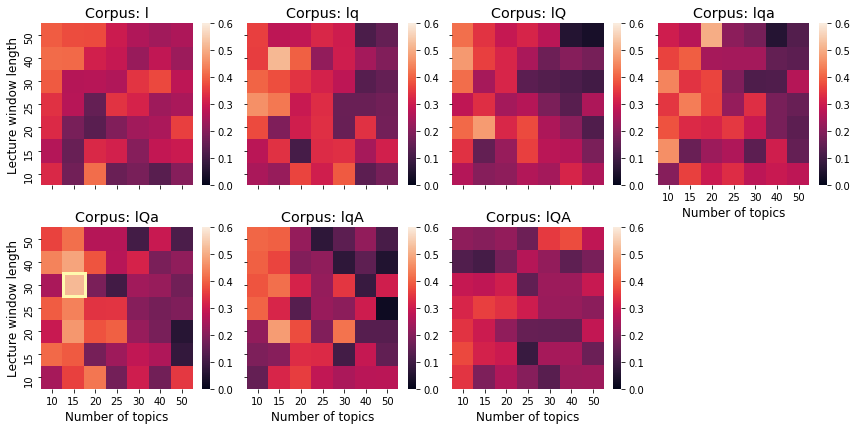

In [14]:
max_score = gs_results['score'].max()
g = sns.FacetGrid(gs_results, col='Corpus', col_wrap=4)
g.map_dataframe(corpus_heatmap, 
                'Number of topics', 
                'Lecture window length', 
                max_score, 
                vmin=0, 
                vmax=0.6)

g.set_titles('{col_var}: {col_name}', size='x-large')
g.set_xlabels(size='large')
g.set_ylabels(size='large')

# g.savefig(FIG_DIR.joinpath('parameter_search.pdf'), bbox_inches='tight')